In [77]:
import numpy as np
import pandas as pd
import yfinance
import matplotlib.pyplot as plt

In [78]:
# downloading the bitcoin historical prices
btc = yfinance.download('BTC-USD', start='2005-01-01', end='2024-06-19')

[*********************100%%**********************]  1 of 1 completed


In [79]:
# visualizing the dataset
btc.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [80]:
# info of the dataset
btc.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3563 entries, 2014-09-17 to 2024-06-18
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3563 non-null   float64
 1   High       3563 non-null   float64
 2   Low        3563 non-null   float64
 3   Close      3563 non-null   float64
 4   Adj Close  3563 non-null   float64
 5   Volume     3563 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 194.9 KB


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


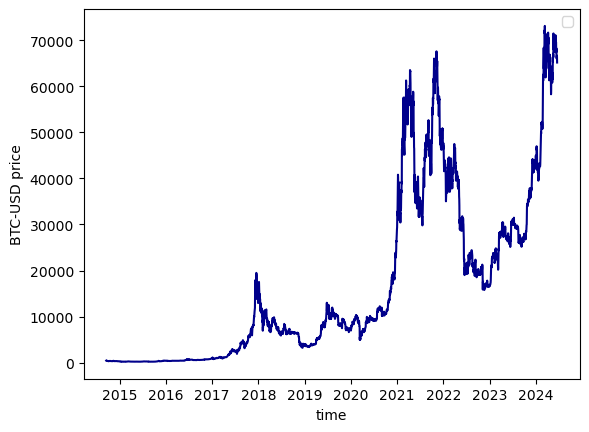

In [219]:
# visualizing the historical data of the BTC-USD price
plt.plot(btc['Close'], color='darkblue')
plt.xlabel('time')
plt.ylabel('BTC-USD price')
plt.legend()
plt.savefig('BTC_historical_prices.png')

In [82]:
from sklearn.preprocessing import MinMaxScaler

In [224]:
# scaling the data
scaler = MinMaxScaler(feature_range=(0, 1))
btc_data = scaler.fit_transform(np.array(btc['Close']).reshape(-1, 1))

In [223]:
btc_data

array([[0.00383005],
       [0.00337886],
       [0.00297225],
       ...,
       [0.91160527],
       [0.90956495],
       [0.89105397]])

In [225]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout

In [87]:
from src.forecaster import Forecaster

In [88]:
# defining the model parameters
history_size, prediction_size = 30, 10
btc_forecaster = Forecaster(
    data=btc_data,
    history_size=history_size,
    prediction_size=prediction_size
)

In [89]:
# defining the model architecture
model_architecture = Sequential([
    Input(shape=(history_size, 1)),
    LSTM(50, return_sequences=True),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(prediction_size)
])

In [226]:
# preparing data, splitting it in to train/test 
btc_forecaster.prepare_data()

In [227]:
# builds the RNN model
btc_forecaster.build_model(history_size, prediction_size, model_architecture)

In [228]:
# compiles the RNN model
btc_forecaster.compile_model()

In [107]:
# training the model
btc_forecaster.train(epochs=20, batch_size=10, initial_epoch=0)

Epoch 1/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 2/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 3/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0012 - val_loss: 0.0018
Epoch 4/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0012 - val_loss: 0.0018
Epoch 5/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 6/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0012 - val_loss: 0.0038
Epoch 7/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0012 - val_loss: 0.0017
Epoch 8/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 9/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0011 - val_loss: 0.0025
Epoch 10/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0011 - val_loss: 0.0016
Epoch 11/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 12/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 

In [229]:
# saving the model
btc_forecaster.model.save('models/btc-model.keras')

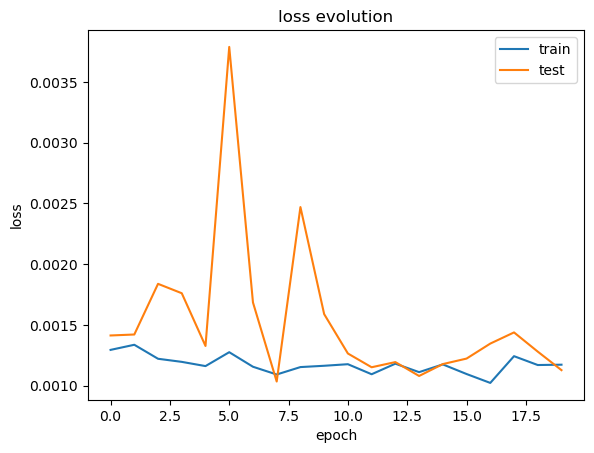

In [230]:
# ploting the loss
history = btc_forecaster.model_history

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss evolution')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [109]:
# selecting the last n = history_size + prediction_size days of the BTC-USD prices to test
btc_last_days = btc_data[-(history_size + prediction_size):]
btc_past_window = btc_last_days[:history_size]
btc_future_window = btc_last_days[-prediction_size:]

In [232]:
# forecasting the last n = prediction_size days of the BTC-USD Open price
btc_predicted_future_window = btc_forecaster.predict(btc_past_window).reshape(prediction_size)

btc_future_window, btc_predicted_future_window

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step


(array([[0.95287718],
        [0.95101571],
        [0.92111052],
        [0.93358088],
        [0.91321491],
        [0.90299201],
        [0.90545967],
        [0.91160527],
        [0.90956495],
        [0.89105397]]),
 array([0.92811316, 0.93917614, 0.926865  , 0.91092086, 0.9198928 ,
        0.9103023 , 0.909348  , 0.9104835 , 0.91956353, 0.9184372 ],
       dtype=float32))

In [233]:
# timestamps for the last 90 days
timestamps = btc.index[-(history_size + prediction_size):]

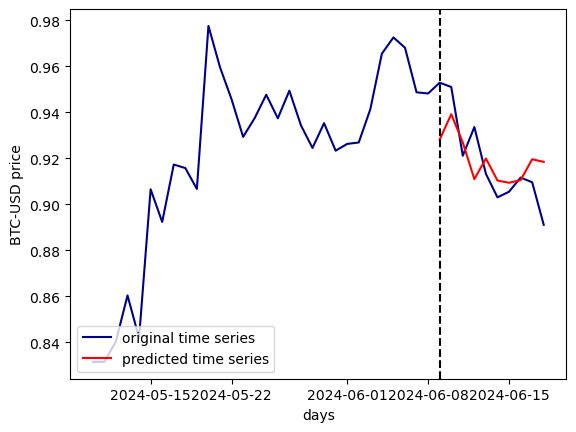

In [235]:
# ploting the prediction for the last 10 days
plt.plot(timestamps, btc_last_days, color='darkblue', label='original time series')
plt.plot(timestamps[-prediction_size:], btc_predicted_future_window, color='red', label='predicted time series')
plt.axvline(timestamps[history_size], linestyle='dashed', color='black')
plt.xlabel('days')
plt.ylabel('BTC-USD price')
plt.legend(loc='lower left')
plt.savefig('last_10_days_prediction.png')

In [122]:
import random

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1353


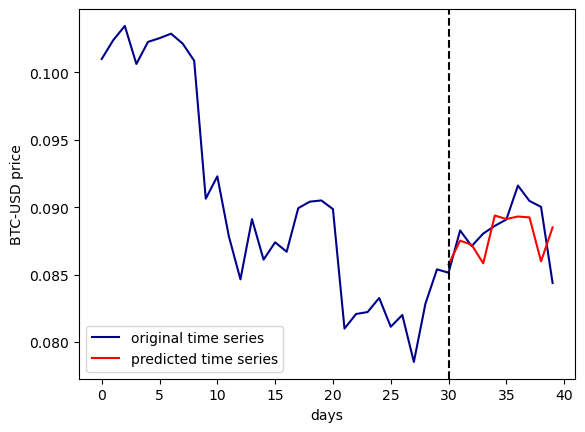

In [217]:
# predicting for other windows

# play with the index ou use the random generated index, for fun xD
rand_index = random.choice(range(0, len(btc_data) - (history_size + prediction_size)))
index = 1353

timestamps = range(history_size + prediction_size)
window = btc_forecaster.data.reshape(-1)[index:index+(history_size + prediction_size)]
past_window = window[:history_size]
future_window = window[-prediction_size:]
predicted_window = btc_forecaster.predict(past_window).reshape(prediction_size)

print(index)

plt.plot(timestamps, window, color='darkblue', label='original time series')
plt.plot(timestamps[-prediction_size:], predicted_window, color='red', label='predicted time series')
plt.axvline(timestamps[history_size], linestyle='dashed', color='black')
plt.xlabel('days')
plt.ylabel('BTC-USD price')
plt.legend(loc='lower left')
plt.savefig('predicted_01.png')